# Pipeline for High-z Radio Galaxies 03: Radio detection classification with confirmed AGN

## Introduction

Training for classification of sources with and without radio detection in the HETDEX field. 

Sources are all elements detected in the CatWISE2020 catalogue.  But classification  
will be done with AGN from the Million Quasar Catalog (MQC) and those predicted  
to be AGN by the initial Galaxy/AGN classification model (`ML_01.ipynb`).  

Being either AGN or galaxy will be used as an additional feature.

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, brier_score_loss
from sklearn.metrics import matthews_corrcoef, precision_recall_curve, PrecisionRecallDisplay, auc
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import sklearn.pipeline
from betacal import BetaCalibration
import ppscore as pps
import seaborn as sns
import colorcet as cc
from pycaret import classification as pyc
from joblib import dump, load
import pandas as pd
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()

In [3]:
plt.rcParams['text.usetex'] = True

***

## Reading data

We import our data using the `pandas` package.

In [4]:
save_plot_flag         = False
save_model_flag        = False
read_idx_flag          = True
use_AGN_gal_model_flag = False
load_model_flag        = True
use_calibration        = True

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [5]:
features_2_discard = ['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI', 
                      'TYPE', 'Z', 'zsp', 'Sint_LOFAR', 'W1mag', 'W2mag', 'spCl', 
                      'num_imputed', 'radio_detect',] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [6]:
full_catalog_df = pd.read_hdf(gv.cat_path + gv.file_HETDEX, key='df').drop(columns=features_2_discard)

In [7]:
# full_catalog_df.describe()

#### Load previous model to create labels for unknown sources (in general, do not use this).

In [8]:
confirmed_indices = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_AGN'] == 1)].index
unknown_indices   = full_catalog_df.drop(index=confirmed_indices).index
final_indices     = confirmed_indices.union(unknown_indices)  # all

In [9]:
print(f'There are {np.sum(full_catalog_df.loc[:, "is_AGN"] == 1):,} confirmed AGN in this dataset.')

There are 54,519 confirmed AGN in this dataset.


In [10]:
if use_AGN_gal_model_flag:
    AGN_gal_clf = pyc.load_model(gv.models_path + gv.AGN_gal_model)  # From ML_16.ipynb

In [11]:
if use_AGN_gal_model_flag:
    new_labels_train   = pyc.predict_model(AGN_gal_clf, data=full_catalog_df,\
                                           probability_threshold=gv.AGN_thresh,\
                                           raw_score=True).loc[:, 'Score_1']

In [12]:
if use_AGN_gal_model_flag:
    full_catalog_df['class'] = new_labels_train.copy()

In [13]:
if use_AGN_gal_model_flag:
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(full_catalog_df.loc[:, 'is_gal'] == 1, 0)
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(full_catalog_df.loc[:, 'is_AGN'] == 1, 1)

#### Select only confirmed and highly likely AGN

In [14]:
if use_AGN_gal_model_flag:
    AGN_threshold = 0.95
    gal_threshold = 0.05

In [15]:
if use_AGN_gal_model_flag:
    filter_upgrade_AGN = (full_catalog_df.loc[:, 'class'] > AGN_threshold) & (full_catalog_df.loc[:, 'class'] < 1.00)
    filter_upgrade_gal = (full_catalog_df.loc[:, 'class'] < gal_threshold) & (full_catalog_df.loc[:, 'class'] > 0.00)
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(filter_upgrade_AGN, 1)
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(filter_upgrade_gal, 0)

In [16]:
if not use_AGN_gal_model_flag:
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'is_AGN'].copy()

In [17]:
full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].astype(int)

In [18]:
target_feat = 'LOFAR_detect'

## Possible correlations

In [19]:
print(full_catalog_df.columns.to_list())

['band_num', 'LOFAR_detect', 'is_str', 'is_SDSS_QSO', 'is_AGN', 'is_SDSS_gal', 'is_gal', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'W3mag', 'W4mag', 'Jmag', 'Hmag', 'Kmag', 'g_r', 'g_i', 'g_z', 'g_y', 'g_J', 'g_H', 'g_K', 'g_W1', 'g_W2', 'g_W3', 'g_W4', 'r_i', 'r_z', 'r_y', 'r_J', 'r_H', 'r_K', 'r_W1', 'r_W2', 'r_W3', 'r_W4', 'i_z', 'i_y', 'i_J', 'i_H', 'i_K', 'i_W1', 'i_W2', 'i_W3', 'i_W4', 'z_y', 'z_J', 'z_H', 'z_K', 'z_W1', 'z_W2', 'z_W3', 'z_W4', 'y_J', 'y_H', 'y_K', 'y_W1', 'y_W2', 'y_W3', 'y_W4', 'J_H', 'J_K', 'J_W1', 'J_W2', 'J_W3', 'J_W4', 'H_K', 'H_W1', 'H_W2', 'H_W3', 'H_W4', 'K_W1', 'K_W2', 'K_W3', 'K_W4', 'W1_W2', 'W1_W3', 'W1_W4', 'W2_W3', 'W2_W4', 'W3_W4', 'class']


---

Create target

In [20]:
full_catalog_df.loc[:, target_feat] = full_catalog_df.loc[:, target_feat].astype(int)

## Split data: Test, Train, Validation

Create same train/test/validation sub-sets as with AGN/galaxy model.  
After this, select sources needed for this model (`class == 1`)

In [21]:
filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) | (full_catalog_df.loc[:, 'is_gal'] == 1)
full_catalog_df   = full_catalog_df.loc[filter_known_spec]
if not read_idx_flag:
    train_test_df, train_df, test_df, calibration_df, validation_df = gf.split_set(full_catalog_df, [0.2, 0.2, 0.5],\
                                                                                   'class', use_calibration=use_calibration)
if read_idx_flag:
    known_idx            = np.loadtxt(gv.indices_path + 'indices_known.txt')
    train_idx            = np.loadtxt(gv.indices_path + 'indices_train.txt')
    train_validation_idx = np.loadtxt(gv.indices_path + 'indices_train_validation.txt')  # in the future, fix naming
    validation_idx       = np.loadtxt(gv.indices_path + 'indices_validation.txt')  # in the future, fix naming
    calibration_idx      = np.loadtxt(gv.indices_path + 'indices_calibration.txt')
    test_idx             = np.loadtxt(gv.indices_path + 'indices_test.txt')
    
    train_test_df  = full_catalog_df.loc[train_validation_idx]
    train_df       = full_catalog_df.loc[train_idx]
    test_df        = full_catalog_df.loc[validation_idx]
    calibration_df = full_catalog_df.loc[calibration_idx]
    validation_df  = full_catalog_df.loc[test_idx]
    
print('Shape of used data in HETDEX')
print('-' * 60)
print(f'Full confirmed dataset size:                      {full_catalog_df.shape}')
print(f'Data for Modeling (Train, Test, and Calibration): {train_test_df.shape}')
print(f'Training data:                                    {train_df.shape}')
print(f'Testing data:                                     {test_df.shape}')
if use_calibration:
    print(f'Calibration data:                                 {calibration_df.shape}')
print(f'Validation data:                                  {validation_df.shape}')
print('-' * 60)
print()

Shape of used data in HETDEX
------------------------------------------------------------
Full confirmed dataset size:                      (158483, 86)
Data for Modeling (Train, Test, and Calibration): (126786, 86)
Training data:                                    (101428, 86)
Testing data:                                     (12679, 86)
Calibration data:                                 (12679, 86)
Validation data:                                  (31697, 86)
------------------------------------------------------------



In [22]:
full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'class'] == 1)]
train_test_df   = train_test_df.loc[(train_test_df.loc[:, 'class'] == 1)]
train_df        = train_df.loc[(train_df.loc[:, 'class'] == 1)]
test_df         = test_df.loc[(test_df.loc[:, 'class'] == 1)]
calibration_df  = calibration_df.loc[(calibration_df.loc[:, 'class'] == 1)]
validation_df   = validation_df.loc[(validation_df.loc[:, 'class'] == 1)]

#### Testing of selecting balanced sub-samples for training

In [23]:
selected_non_radio_idx_train_test = train_test_df.loc[(train_test_df.loc[:, 'LOFAR_detect'] == 0)].sample(n=np.sum(train_test_df.loc[:, 'LOFAR_detect'] == 1), 
                                                                                                          random_state=gv.seed).index
selected_radio_idx_train_test     = train_test_df.loc[(train_test_df.loc[:, 'LOFAR_detect'] == 1)].index

selected_non_radio_idx_train      = train_df.loc[(train_df.loc[:, 'LOFAR_detect'] == 0)].sample(n=np.sum(train_df.loc[:, 'LOFAR_detect'] == 1), 
                                                                                                random_state=gv.seed).index
selected_radio_idx_train          = train_df.loc[(train_df.loc[:, 'LOFAR_detect'] == 1)].index

selected_non_radio_idx_test       = test_df.loc[(test_df.loc[:, 'LOFAR_detect'] == 0)].sample(n=np.sum(test_df.loc[:, 'LOFAR_detect'] == 1), 
                                                                                              random_state=gv.seed).index
selected_radio_idx_test           = test_df.loc[(test_df.loc[:, 'LOFAR_detect'] == 1)].index

selected_non_radio_idx_calib      = calibration_df.loc[(calibration_df.loc[:, 'LOFAR_detect'] == 0)].sample(n=np.sum(calibration_df.loc[:, 'LOFAR_detect'] == 1), 
                                                                                                            random_state=gv.seed).index
selected_radio_idx_calib          = calibration_df.loc[(calibration_df.loc[:, 'LOFAR_detect'] == 1)].index

In [24]:
needed_idx_train_test             = pd.Index(selected_non_radio_idx_train_test.to_list() + selected_radio_idx_train_test.to_list())
needed_idx_train                  = pd.Index(selected_non_radio_idx_train.to_list()      + selected_radio_idx_train.to_list())
needed_idx_test                   = pd.Index(selected_non_radio_idx_test.to_list()       + selected_radio_idx_test.to_list())
needed_idx_calib                  = pd.Index(selected_non_radio_idx_calib.to_list()      + selected_radio_idx_calib.to_list())

In [25]:
train_test_df  = train_test_df.loc[needed_idx_train_test]
train_df       = train_df.loc[needed_idx_train]
test_df        = test_df.loc[needed_idx_test]
calibration_df = calibration_df.loc[needed_idx_calib]

In [26]:
n_is_AGN = np.sum(full_catalog_df.loc[:, 'class'] == 1)
n_is_rad = np.sum(full_catalog_df.loc[:, target_feat] == 1)
print(f'In this dataset (HETDEX), with {len(full_catalog_df.loc[:, "is_AGN"]):,} elements,\n' +\
         f'{n_is_AGN:,} of them are marked as AGN, and, from them, {n_is_rad:,} have confirmed radio detection.')

In this dataset (HETDEX), with 54,519 elements,
54,519 of them are marked as AGN, and, from them, 8,374 have confirmed radio detection.


Remove intermediate targets

In [27]:
cols_to_discard_classes = ['is_AGN', 'is_SDSS_QSO', 'is_SDSS_gal', 'is_gal', 'class', 'is_str']
full_catalog_df = full_catalog_df.drop(columns=cols_to_discard_classes)
train_test_df   = train_test_df.drop(columns=cols_to_discard_classes)
train_df        = train_df.drop(columns=cols_to_discard_classes)
test_df         = test_df.drop(columns=cols_to_discard_classes)
calibration_df  = calibration_df.drop(columns=cols_to_discard_classes)
validation_df   = validation_df.drop(columns=cols_to_discard_classes)

---

In [28]:
print('Final shape of used data')
print('-' * 65)
print('(Confirmed AGN)')
print('-' * 50)
print(f'Full confirmed dataset size:        {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Training data:                      {train_df.shape}')
print(f'Testing data:                       {test_df.shape}')
print(f'Calibration data:                   {calibration_df.shape}')
print(f'Validation data:                    {validation_df.shape}')
print('-' * 65)

Final shape of used data
-----------------------------------------------------------------
(Confirmed AGN)
--------------------------------------------------
Full confirmed dataset size:        (54519, 80)
Data for Modeling (Train and Test): (13358, 80)
Training data:                      (10624, 80)
Testing data:                       (1338, 80)
Calibration data:                   (1396, 80)
Validation data:                    (10904, 80)
-----------------------------------------------------------------


---

## Use Correlation matrix to discard some features

In [29]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_df.columns, index=train_test_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [30]:
rsd_vals = (train_test_df.std() / train_test_df.mean() * 100).sort_values(ascending=False)

In [31]:
rsd_vals

z_y             457.163974
K_W3            372.548419
i_z             300.183923
i_y             221.971329
r_i             162.812317
g_r             135.997284
r_y             134.543571
r_z             130.064979
g_i             109.095959
g_y             102.797577
W1_W2           102.584983
LOFAR_detect    100.003743
g_z              99.842932
y_W1             67.187419
H_W3             65.034774
z_W1             58.782342
i_W1             54.136761
g_W1             53.552929
y_W2             53.459389
r_W1             53.313050
J_W3             51.084975
z_W2             46.428056
y_J              45.309982
i_W2             42.593141
y_H              41.548821
g_W2             41.536725
r_W2             41.443261
z_J              41.283825
i_J              39.489748
z_H              37.989746
r_J              37.271976
W2_W3            37.091026
i_H              36.496992
y_K              35.723581
W1_W3            35.388069
r_H              34.664131
g_J              34.635160
z

In [32]:
correlation    = norm_train_test_df.corr()

In [33]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [34]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [35]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [36]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [37]:
list_drop_corr

['y_H',
 'g_H',
 'r_H',
 'i_H',
 'z_H',
 'J_W1',
 'J_W2',
 'J_W3',
 'y_K',
 'i_K',
 'z_K',
 'r_K',
 'H_W1',
 'g_K',
 'Jmag',
 'H_W2',
 'J_W4',
 'K_W1',
 'K_W2',
 'W2mproPM',
 'ymag',
 'W1mproPM',
 'imag',
 'zmag',
 'rmag',
 'Kmag',
 'gmag',
 'W1_W4',
 'r_W4',
 'y_W4',
 'H_W3',
 'r_J',
 'g_W4',
 'i_W4',
 'W2_W4',
 'z_W4',
 'g_W2',
 'i_J',
 'r_W3',
 'W1_W3',
 'J_K',
 'i_W3',
 'r_W2',
 'r_W1',
 'y_W2',
 'H_W4',
 'z_J',
 'y_W3',
 'i_W2',
 'z_W2',
 'g_W3',
 'W3mag',
 'Hmag',
 'i_W1',
 'g_y',
 'g_z',
 'r_y',
 'W3_W4',
 'g_i',
 'z_W3',
 'g_J',
 'g_W1']

In [38]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [39]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [40]:
corr_discard = norm_train_test_discard.corr()

In [41]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

band_num  band_num    1.000000
y_J       band_num    0.743254
z_W1      y_W1        0.740478
i_y       z_y         0.739132
W2_W3     y_J         0.734537
W4mag     K_W3        0.712058
K_W3      K_W4        0.669553
r_z       i_z         0.639073
band_num  W2_W3       0.605401
W4mag     K_W4        0.593887
r_i       r_z         0.581124
y_J       K_W3        0.550002
band_num  H_K         0.542745
H_K       W1_W2       0.497055
band_num  K_W3        0.490912
dtype: float64

Text(1052.0930609538775, 0.5, 'feature')

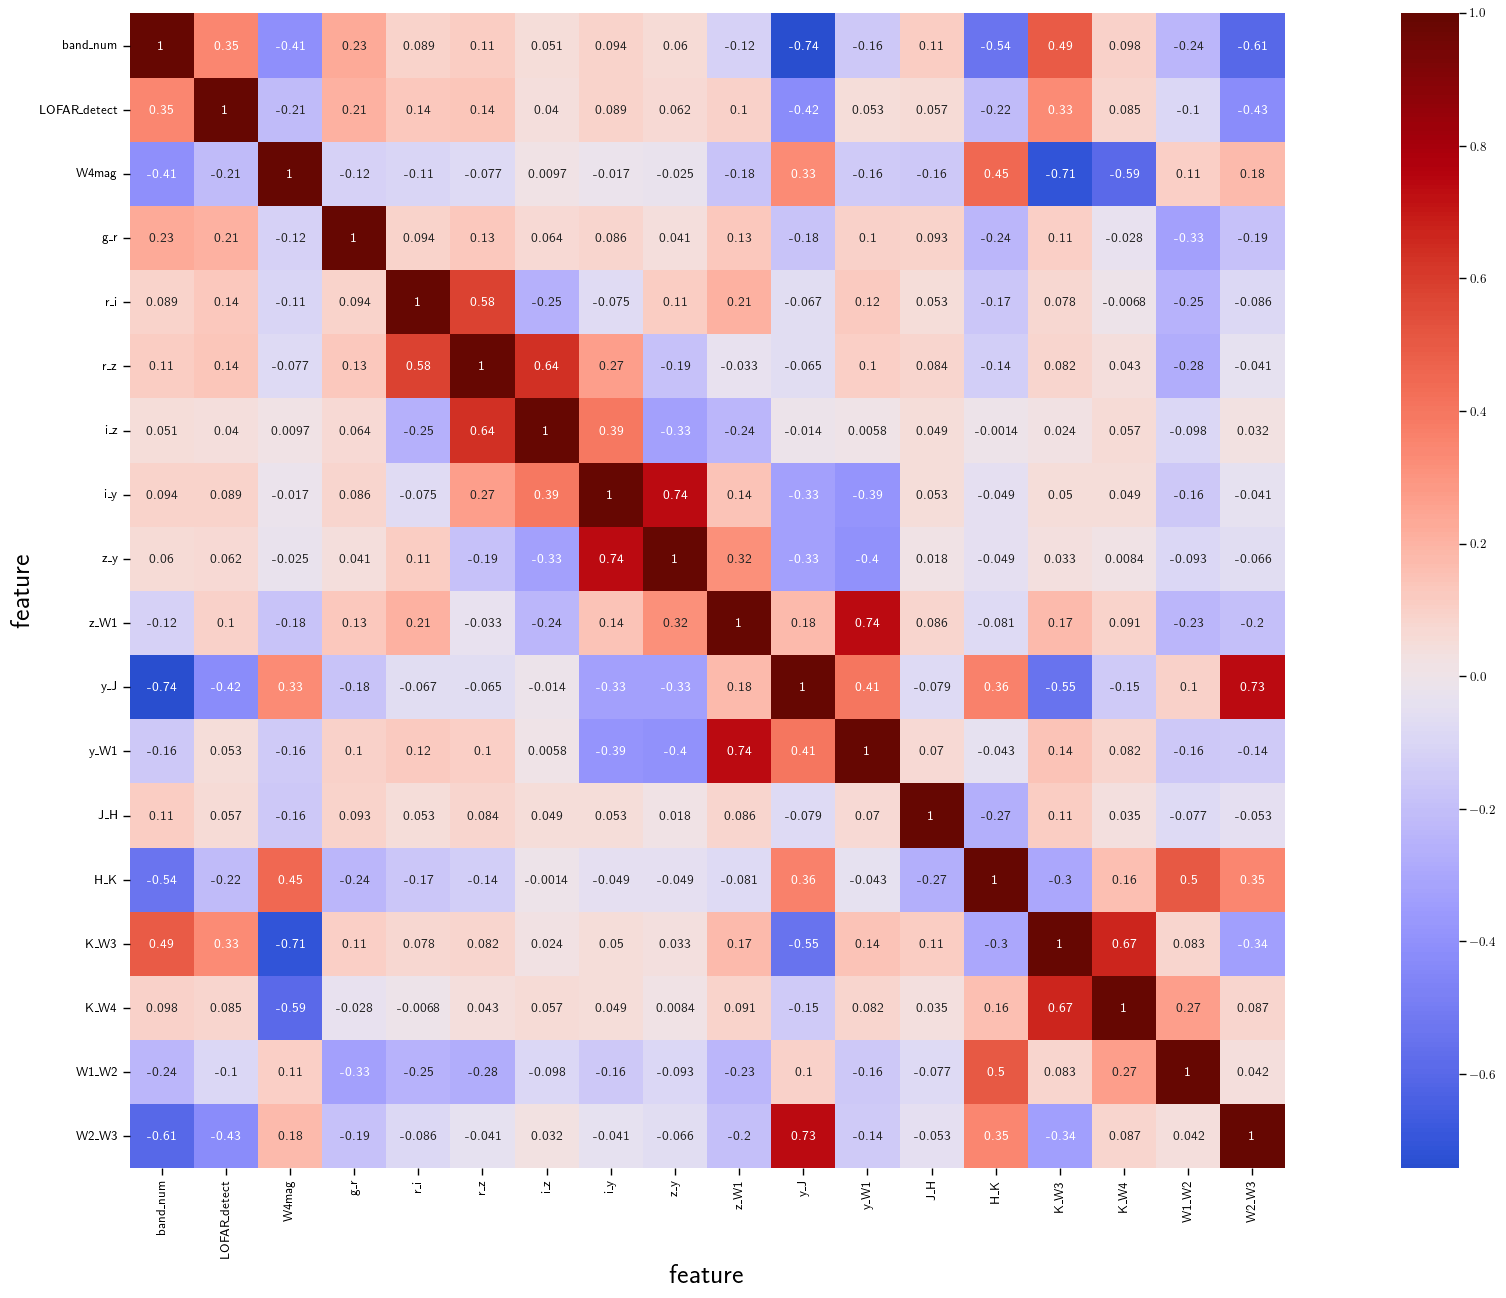

In [42]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')

In [43]:
norm_train_test_discard.loc[:, target_feat] = norm_train_test_discard.loc[:, target_feat].astype(bool)

In [44]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=gv.seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [45]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x         y           
H_K       H_K             1.000000
band_num  y_J             0.554496
K_W4      W4mag           0.495336
K_W3      K_W4            0.318360
J_H       H_K             0.316127
y_W1      z_W1            0.280901
band_num  z_y             0.275658
          W2_W3           0.273824
y_J       LOFAR_detect    0.260009
          band_num        0.256626
K_W4      K_W3            0.249625
K_W3      LOFAR_detect    0.247934
band_num  LOFAR_detect    0.243102
K_W3      W4mag           0.235299
z_W1      y_W1            0.231823
W2_W3     LOFAR_detect    0.219726
K_W3      W2_W3           0.216498
band_num  H_K             0.214209
z_y       i_y             0.206445
K_W3      y_J             0.197143
dtype: float64

In [46]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [47]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [48]:
list_drop_pps = []

In [49]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [50]:
list_drop_pps

[]

In [51]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [52]:
pps_pred_target = pps.predictors(norm_train_test_discard, target_feat, random_seed=gv.seed)

In [53]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,y_J,LOFAR_detect,0.260009,classification,True,weighted F1,0.4932,0.624972,DecisionTreeClassifier()
1,K_W3,LOFAR_detect,0.247934,classification,True,weighted F1,0.4932,0.618853,DecisionTreeClassifier()
2,band_num,LOFAR_detect,0.243102,classification,True,weighted F1,0.4932,0.616404,DecisionTreeClassifier()
3,W2_W3,LOFAR_detect,0.219726,classification,True,weighted F1,0.4932,0.604557,DecisionTreeClassifier()
4,y_W1,LOFAR_detect,0.133733,classification,True,weighted F1,0.4932,0.560976,DecisionTreeClassifier()
5,W1_W2,LOFAR_detect,0.112536,classification,True,weighted F1,0.4932,0.550233,DecisionTreeClassifier()
6,g_r,LOFAR_detect,0.109873,classification,True,weighted F1,0.4932,0.548884,DecisionTreeClassifier()
7,r_i,LOFAR_detect,0.073369,classification,True,weighted F1,0.4932,0.530383,DecisionTreeClassifier()
8,z_y,LOFAR_detect,0.060309,classification,True,weighted F1,0.4932,0.523765,DecisionTreeClassifier()
9,i_y,LOFAR_detect,0.050054,classification,True,weighted F1,0.4932,0.518568,DecisionTreeClassifier()


In [54]:
print(f'{len(full_catalog_df):,}')

54,519


---

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [55]:
final_feats = pps_pred_target.x.to_list()  # Before Boruta

In [56]:
feats_2_discard = list_drop_corr + list_drop_pps

Boruta discards no features.

In [58]:
exp_radio = pyc.setup(data                     = train_df,
                      test_data                = test_df,
                      target                   = target_feat,
                      session_id               = gv.seed,
                      silent                   = True,
                      feature_selection        = False,
                      feature_selection_method = 'boruta',
                      data_split_stratify      = True,
                      numeric_features         = final_feats,
                      ignore_features          = feats_2_discard,
                      transformation           = True,
                      transformation_method    = 'yeo-johnson',
                      n_jobs                   = 12,
                      normalize                = True,
                      normalize_method         = 'zscore',
                      use_gpu                  = False)  # 15 minutes with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,LOFAR_detect
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(10624, 80)"
5,Missing Values,False
6,Numeric Features,17
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [59]:
pyc.get_config('X').columns

Index(['band_num', 'W4mag', 'g_r', 'r_i', 'r_z', 'i_z', 'i_y', 'z_y', 'z_W1',
       'y_J', 'y_W1', 'J_H', 'H_K', 'K_W3', 'K_W4', 'W1_W2', 'W2_W3'],
      dtype='object')

In [56]:
pyc.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


Add F_beta score ($\beta = 1.1$).

In [60]:
pyc.add_metric('f_beta', 'F_score', gf.f_beta, greater_is_better=True)

Name                                             F_score
Display Name                                     F_score
Score Function       <function f_beta at 0x7f9b199bb310>
Scorer                               make_scorer(f_beta)
Target                                              pred
Args                                                  {}
Greater is Better                                   True
Multiclass                                          True
Custom                                              True
Name: f_beta, dtype: object

In [58]:
pyc.models(internal=True).loc['gbc']['Tune Grid'].keys()

dict_keys(['n_estimators', 'learning_rate', 'subsample', 'min_samples_split', 'min_samples_leaf', 'max_depth', 'min_impurity_decrease', 'max_features'])

In [61]:
metric_2_sort         = 'Recall'
final_selection_clf   = ['rf', 'catboost', 'xgboost', 'et', 'gbc', 'dummy']  # lightgbm is selected to be base learner.
initial_selection_clf = ['rf', 'gbc', 'et', 'xgboost', 'catboost', 'dummy']  # Only tree-based models (except lightgbm,dt)
n_models              = 5
top_model_radio = pyc.compare_models(n_select = n_models,
                                     include  = final_selection_clf,
                                     sort     = metric_2_sort)  # 1:15 hour for used_models_clf
# top_model_radio = pyc.compare_models(n_select=n_models, include=initial_selection_clf, sort=metric_2_sort)  # 10 minutes, using all models.

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score,TT (Sec)
catboost,CatBoost Classifier,0.7275,0.7985,0.7016,0.7399,0.7202,0.4550,0.4556,0.7184,0.9320
rf,Random Forest Classifier,0.7226,0.7888,0.7009,0.7329,0.7165,0.4452,0.4457,0.7149,0.5240
xgboost,Extreme Gradient Boosting,0.7120,0.7792,0.6918,0.7209,0.7060,0.4239,0.4243,0.7047,8.1580
et,Extra Trees Classifier,0.7162,0.7866,0.6896,0.7286,0.7084,0.4324,0.4332,0.7066,0.0880
gbc,Gradient Boosting Classifier,0.7217,0.7951,0.6822,0.7407,0.7102,0.4433,0.4448,0.7074,0.3820
dummy,Dummy Classifier,0.4998,0.5000,0.2000,0.0999,0.1332,0.0000,0.0000,0.1376,0.0040


Thus, we will select `catboost` as meta learner.

Thus, we stack the models.

In [62]:
# base_models = top_model_radio[0:2] + top_model_radio[3:]
# meta_model  = top_model_radio[2]
base_models = top_model_radio[1:]
meta_model  = top_model_radio[0]

In [63]:
stacked_model_radio = pyc.stack_models(estimator_list = base_models,
                                       meta_model     = meta_model,
                                       optimize       = metric_2_sort,
                                       restack        = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
Fold,,,,,,,,
0,0.7469,0.8109,0.7401,0.7500,0.7450,0.4939,0.4939,0.7446
1,0.7206,0.7912,0.7043,0.7276,0.7158,0.4412,0.4414,0.7147
2,0.7197,0.7846,0.7011,0.7285,0.7146,0.4393,0.4397,0.7133
3,0.7178,0.7856,0.6917,0.7302,0.7104,0.4356,0.4362,0.7086
4,0.7241,0.7932,0.6911,0.7399,0.7147,0.4482,0.4492,0.7124
5,0.7335,0.7998,0.7194,0.7403,0.7297,0.4670,0.4672,0.7287
6,0.7316,0.7990,0.7062,0.7440,0.7246,0.4633,0.4639,0.7228
7,0.7354,0.8038,0.7137,0.7461,0.7295,0.4708,0.4713,0.7280
8,0.6987,0.7857,0.6893,0.7025,0.6958,0.3974,0.3974,0.6952


In [62]:
catboost_tune_grid          = pyc.models(internal=True).loc['catboost']['Tune Grid']
catboost_tune_grid['depth'] = [4, 5, 6, 7, 8, 9, 10, 11]  # old = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [64]:
# tuned_radio_clf = pyc.tune_model(estimator        = stacked_model_radio,
#                                  early_stopping   = True,
#                                  optimize         = metric_2_sort,
#                                  search_library   = 'tune-sklearn',
#                                  search_algorithm = 'bayesian',
#                                  choose_better    = True,
#                                  custom_grid      = catboost_tune_grid)  # 1h30
tuned_radio_clf = pyc.tune_model(estimator        = stacked_model_radio,
                                 early_stopping   = True,
                                 optimize         = metric_2_sort,
                                 search_library   = 'tune-sklearn',
                                 search_algorithm = 'bayesian',
                                 choose_better    = True)  # 1h30

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
Fold,,,,,,,,
0,0.7432,0.8106,0.7269,0.7510,0.7388,0.4863,0.4866,0.7376
1,0.7244,0.7935,0.7006,0.7352,0.7175,0.4487,0.4492,0.7158
2,0.7131,0.7818,0.6898,0.7239,0.7064,0.4262,0.4266,0.7048
3,0.7150,0.7915,0.7180,0.7140,0.7160,0.4299,0.4299,0.7162
4,0.7288,0.8003,0.6780,0.7547,0.7143,0.4576,0.4600,0.7107
5,0.7382,0.7984,0.7420,0.7364,0.7392,0.4765,0.4765,0.7395
6,0.7194,0.7944,0.6968,0.7298,0.7129,0.4388,0.4392,0.7113
7,0.7250,0.7937,0.6780,0.7484,0.7115,0.4501,0.4521,0.7081
8,0.7015,0.7829,0.7194,0.6945,0.7068,0.4030,0.4033,0.7079


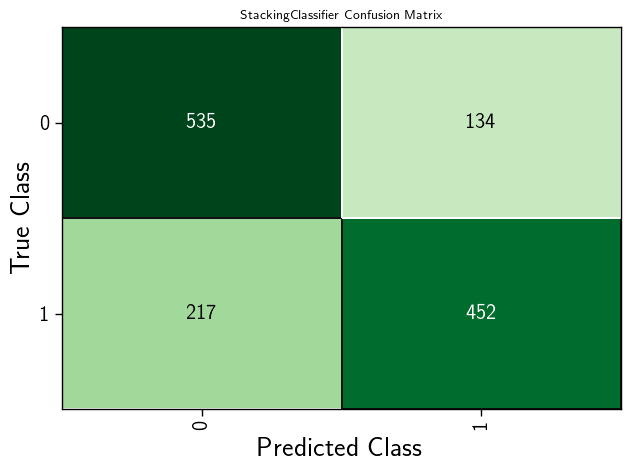

In [65]:
pyc.plot_model(tuned_radio_clf, plot='confusion_matrix')

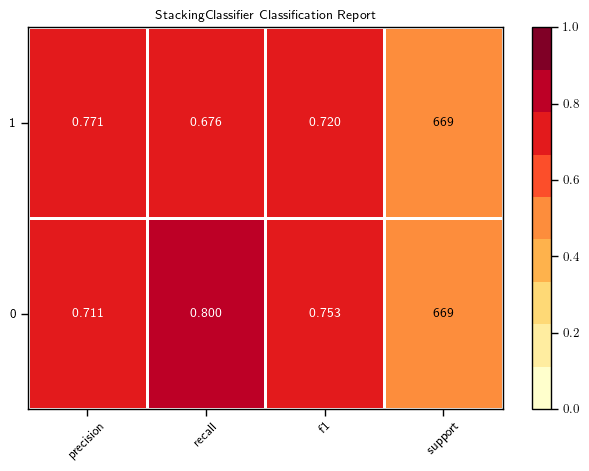

In [66]:
pyc.plot_model(tuned_radio_clf, plot='class_report')

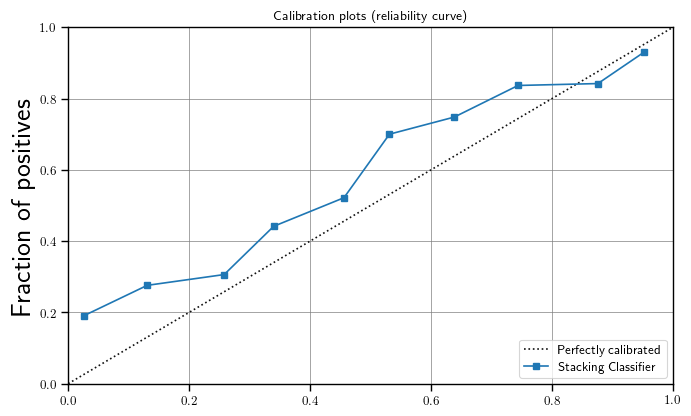

In [67]:
pyc.plot_model(tuned_radio_clf, plot='calibration')

In [79]:
# pyc.plot_model(tuned_radio_clf.estimators_[0], plot='feature_all')

In [68]:
pyc.plot_model(tuned_radio_clf.final_estimator_, plot='parameter')

,Parameters
nan_mode,Min
eval_metric,Logloss
iterations,12
sampling_frequency,PerTree
leaf_estimation_method,Newton
grow_policy,SymmetricTree
penalties_coefficient,1
boosting_type,Plain
model_shrink_mode,Constant
feature_border_type,GreedyLogSum


In [69]:
pyc.plot_model(tuned_radio_clf.final_estimator, plot='parameter')

,Parameters
depth,7
l2_leaf_reg,16
border_count,254
thread_count,12
verbose,False
random_strength,0.01844994003313261
task_type,CPU
n_estimators,12
random_state,42
eta,0.0033037608437333534


In [70]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['text.usetex'] = True

In [71]:
pyc.predict_model(tuned_radio_clf, data=test_df, probability_threshold=gv.naive_radio_thresh,\
                  raw_score=True, round=10).loc[:, ['Score_0', 'Score_1']].describe()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.7376681614,0.7985917003,0.6756352765,0.7713310580,0.7203187251,0.4753363229,0.4790373671,0.7158202529


,Score_0,Score_1
count,1338.000000,1338.000000
mean,0.499721,0.500279
std,0.012592,0.012592
min,0.474616,0.484035
25%,0.490879,0.488795
50%,0.501605,0.498395
75%,0.511205,0.509121
max,0.515965,0.525384


In [72]:
test_prediction_clf = pyc.predict_model(tuned_radio_clf, probability_threshold=gv.naive_radio_thresh, raw_score=True, round=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.7376681614,0.7985917003,0.6756352765,0.7713310580,0.7203187251,0.4753363229,0.4790373671,0.7158202529


In [73]:
final_radio_clf = pyc.finalize_model(tuned_radio_clf)

/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_c

In [74]:
pyc.predict_model(final_radio_clf, probability_threshold=gv.naive_radio_thresh,\
                  raw_score=True, round=10).loc[:, ['Score_0', 'Score_1']].describe()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.7376681614,0.7985917003,0.6756352765,0.7713310580,0.7203187251,0.4753363229,0.4790373671,0.7158202529


,Score_0,Score_1
count,1338.000000,1338.000000
mean,0.499721,0.500279
std,0.012592,0.012592
min,0.474616,0.484035
25%,0.490879,0.488795
50%,0.501605,0.498395
75%,0.511205,0.509121
max,0.515965,0.525384


In [74]:
if save_model_flag:
    pyc.save_model(final_radio_clf, gv.models_path + gv.radio_model)  # Model (it will be saved with .pkl extension)

Transformation Pipeline and Model Successfully Saved


## Load Models

AGN detection model.

In [59]:
if load_model_flag:
    final_radio_clf = pyc.load_model(gv.models_path + gv.radio_model)

Transformation Pipeline and Model Successfully Loaded


### Prediction process

#### Feature importances

In [75]:
base_models_names = gf.get_base_estimators_names(final_radio_clf)
base_models       = gf.get_base_estimators_models(final_radio_clf)

In [76]:
print('Running data pre-processing:\n')
extended_data_radio_df = gf.preprocess_data(final_radio_clf, validation_df, base_models_names)

Running data pre-processing:



In [77]:
coef_sorted_meta_df = gf.feat_importances_meta_model(final_radio_clf, extended_data_radio_df)

In [78]:
coef_sorted_base_df = gf.feat_importances_base_models(base_models_names, base_models, extended_data_radio_df)

In [79]:
multicol_feat = [(key, name) for key in coef_sorted_base_df.keys() for name in ('Feature', 'Importance')]

In [80]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(f'Calculating for {key}...')
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    # display(coef_sorted_base_df_copy_sum[key])
coef_sorted_base_full_df = pd.concat([coef_sorted_base_df_copy_sum[key].reset_index(drop=True) for key in coef_sorted_base_df_copy_sum.keys()], axis=1)
coef_sorted_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat)
display(coef_sorted_base_full_df)

Feature importances scaled to sum 100
Calculating for rf...
Calculating for xgboost...
Calculating for et...
Calculating for gbc...


rf              xgboost                   et                  gbc  \
     Feature Importance   Feature Importance   Feature Importance   Feature   
0      W2_W3  14.326513      K_W3  23.893343     W2_W3  12.857423     W2_W3   
1        y_J   9.254517     W2_W3  16.788017       y_J   9.384873      K_W3   
2        g_r   8.535137     W4mag  10.415680       g_r   7.535489       y_J   
3        r_z   7.463688       g_r   4.545597       r_z   7.296072       g_r   
4        r_i   7.434635       r_z   4.356467       r_i   7.208120       r_z   
5      W1_W2   6.976189       y_J   4.302840     W1_W2   7.117214     W1_W2   
6       z_W1   6.743549     W1_W2   3.979293      z_W1   6.943043      y_W1   
7        i_y   6.727137      y_W1   3.932861       i_y   6.863868     W4mag   
8       K_W3   6.687970      z_W1   3.714602      y_W1   6.613780      z_W1   
9        i_z   6.628289       z_y   3.698085       i_z   6.582627       r_i   
10       z_y   6.576068       r_i   3.534650       z_y   6.577630       i_y   
11      y_W1   6.389516       i_y   3.366170      K_W3   5.129782       z_y   
12  band_num   2.904671       i_z   3.131305     W4mag   4.262188       i_z   
13     W4mag   1.436508  band_num   2.949687  band_num   4.070756       H_K   
14      K_W4   0.819504      K_W4   2.632956       H_K   0.642425  band_num   
15       H_K   0.726597       J_H   2.395117      K_W4   0.523658       J_H   
16       J_H   0.369511       H_K   2.363334       J_H   0.391051      K_W4   

               
   Importance  
0   41.280073  
1   18.876173  
2   14.129188  
3    6.063717  
4    4.819391  
5    3.150015  
6    2.713629  
7    2.061157  
8    1.910619  
9    1.648692  
10   1.192354  
11   0.748946  
12   0.569553  
13   0.457311  
14   0.237821  
15   0.082320  
16   0.059040

In [81]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
coef_sorted_meta_df_copy_sum['Cumulative_sum'] = coef_sorted_meta_df_copy_sum.loc[:, 'Importance'].cumsum()
print('Meta model')
display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance,Cumulative_sum
0,rf,52.741557,52.741557
1,xgboost,29.616029,82.357586
2,et,4.787639,87.145225
3,gbc,3.204019,90.349245
4,W2_W3,2.813606,93.162850
5,K_W3,2.255526,95.418377
6,W1_W2,1.514476,96.932853
7,i_y,0.866133,97.798985
8,g_r,0.642418,98.441403
9,y_W1,0.601591,99.042994


In [82]:
print('Combined feature importances scaled to sum 100')
coef_sorted_comb_sum = coef_sorted_meta_df_copy_sum.copy().set_index('Feature')
for key in coef_sorted_base_df_copy_sum.keys():
    factor = coef_sorted_meta_df_copy_sum.set_index('Feature').loc[key] / 100
    tmp_feat_imp = coef_sorted_base_full_df.loc[:, key].copy().set_index('Feature')
    coef_sorted_comb_sum = coef_sorted_comb_sum + tmp_feat_imp * factor
    coef_sorted_comb_sum = coef_sorted_comb_sum.sort_values(by=['Importance'], ascending=False)#.drop(index=base_models_names)
    coef_sorted_comb_sum['Cumulative_sum'] = coef_sorted_comb_sum.loc[:, 'Importance'].cumsum()
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(coef_sorted_comb_sum.drop(index=base_models_names))

Combined feature importances scaled to sum 100


,Cumulative_sum,Importance
Feature,,
W2_W3,17.2798,17.2798
K_W3,30.9893,13.7095
y_J,38.0466,7.0573
g_r,45.0919,7.0453
W1_W2,51.9059,6.8140
r_z,58.1945,6.2887
i_y,63.9724,5.7779
y_W1,69.5123,5.5399
z_W1,74.9614,5.4491


Feature importances scaled to sum 100
--------------------
top features:
Feature	Importance
W2_W3	17.280
K_W3	13.710
y_J	7.057
g_r	7.045
W1_W2	6.814
r_z	6.289
i_y	5.778
y_W1	5.540
z_W1	5.449
r_i	5.366
z_y	4.902
i_z	4.757
W4mag	4.112
band_num	2.608
K_W4	1.239
H_K	1.129
J_H	0.926


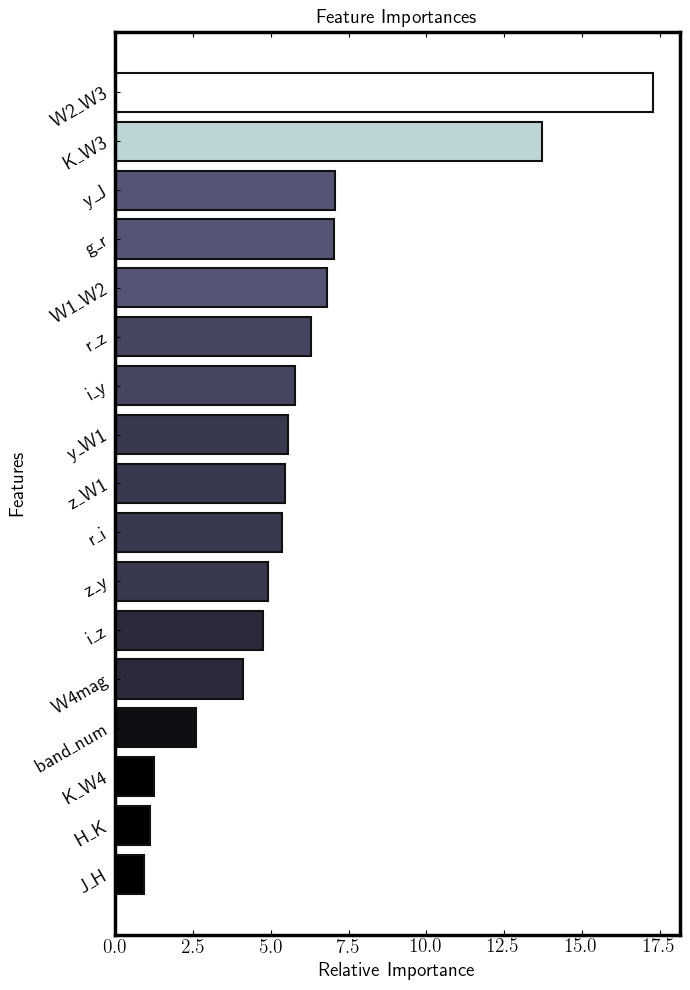

In [83]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    features_df = coef_sorted_comb_sum.sort_values(by=['Importance'], ascending=True).drop(index=base_models_names)
    features    = features_df.index.to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), importances,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig(gv.plots_path + 'feat_imp_classification_radio_detect_05.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(importances)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

#### List optimised hyperparameters

In [84]:
hyperparams_models_df = gf.obtain_optimised_hyperpars(final_radio_clf, 'gbc', 'classification')
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(hyperparams_models_df)

,gbc,rf,xgboost,et,gbc
learning_rate,0.0033,NaN,0.3000,NaN,0.1000
subsample,0.8000,NaN,1.0000,NaN,1.0000
n_estimators,NaN,100,100,100,100
max_depth,NaN,NaN,6.0000,NaN,3.0000
min_impurity_decrease,NaN,0.0000,NaN,0.0000,0.0000
max_features,NaN,auto,NaN,auto,None
bootstrap,NaN,True,NaN,False,NaN
criterion,NaN,gini,NaN,gini,NaN
class_weight,NaN,NaN,NaN,NaN,NaN
min_samples_split,NaN,2.0000,NaN,2.0000,2.0000


---

In [85]:
print(f'Size of train set is {len(train_df):,}')
print(f'Size of test set is  {len(test_df):,}')

Size of train set is 10,624
Size of test set is  1,338


#### Calculate optimal threshold for classification

In [86]:
train_prediction_clf      = pyc.predict_model(final_radio_clf, data=train_df,       probability_threshold=gv.naive_radio_thresh, raw_score=True, round=10)
test_prediction_clf       = pyc.predict_model(final_radio_clf, data=test_df,        probability_threshold=gv.naive_radio_thresh, raw_score=True, round=10)
train_test_prediction_clf = pyc.predict_model(final_radio_clf, data=train_test_df,  probability_threshold=gv.naive_radio_thresh, raw_score=True, round=10)
calib_prediction_clf      = pyc.predict_model(final_radio_clf, data=calibration_df, probability_threshold=gv.naive_radio_thresh, raw_score=True, round=10)
validation_prediction_clf = pyc.predict_model(final_radio_clf, data=validation_df,  probability_threshold=gv.naive_radio_thresh, raw_score=True, round=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.8361257530,0.9413118400,0.8552334337,0.8237533998,0.8391983005,0.6722515060,0.6727429271,0.8406960964


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.7376681614,0.7985917003,0.6756352765,0.7713310580,0.7203187251,0.4753363229,0.4790373671,0.7158202529


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.8058092529,0.8835412647,0.8239257374,0.7951163127,0.8092647059,0.6116185058,0.6120203765,0.8106353879


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.7757879656,0.8392993489,0.7277936963,0.8050713154,0.7644845749,0.5515759312,0.5541346818,0.7608398199


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.7641232575,0.8041100937,0.6778761062,0.3618897638,0.4718685832,0.3376098715,0.3651770620,0.4859001935


#### Naive threshold metrics.

In [87]:
cm_mat_train_naive      = gf.conf_mat_func(train_prediction_clf[target_feat],      train_prediction_clf['Label'])
cm_mat_test_naive       = gf.conf_mat_func(test_prediction_clf[target_feat],       test_prediction_clf['Label'])
cm_mat_train_test_naive = gf.conf_mat_func(train_test_prediction_clf[target_feat], train_test_prediction_clf['Label'])
cm_mat_calib_naive      = gf.conf_mat_func(calib_prediction_clf[target_feat],      calib_prediction_clf['Label'])
cm_mat_val_naive        = gf.conf_mat_func(validation_prediction_clf[target_feat], validation_prediction_clf['Label'])

In [88]:
naive_scores_df = gf.create_scores_df([cm_mat_train_naive, cm_mat_test_naive, cm_mat_train_test_naive, cm_mat_calib_naive, cm_mat_val_naive],\
                       ['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                       ['F-\u03B2', 'MCC', 'Precision', 'Recall', 'ACC'])

In [89]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(naive_scores_df.drop(columns=['ACC']))

,F-β,MCC,Precision,Recall
Train,0.8407,0.6727,0.8238,0.8552
Test,0.7158,0.4790,0.7713,0.6756
Train+Test,0.8106,0.6120,0.7951,0.8239
Calibration,0.7608,0.5541,0.8051,0.7278
Validation,0.4859,0.3652,0.3619,0.6779


#### Calibration curve

In [90]:
fract_positiv_train_test, mean_pred_val_train_test =\
                        calibration_curve(train_test_prediction_clf.loc[:, target_feat],\
                                          train_test_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_calib, mean_pred_val_calib =\
                        calibration_curve(calib_prediction_clf.loc[:, target_feat],\
                                          calib_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_val, mean_pred_val_val =\
                        calibration_curve(validation_prediction_clf.loc[:, target_feat],\
                                          validation_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

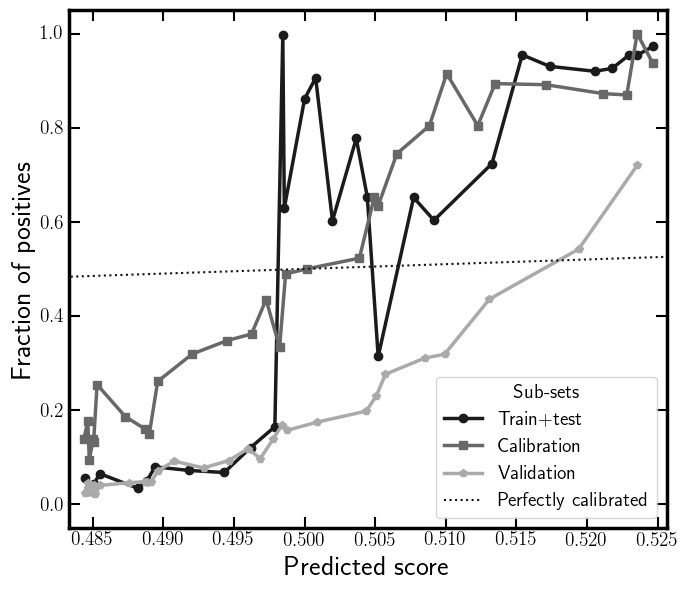

In [91]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

min_x = np.nanmin([np.nanmin(train_test_prediction_clf.loc[:, 'Score_1']),\
                   np.nanmin(calib_prediction_clf.loc[:, 'Score_1']),\
                   np.nanmin(validation_prediction_clf.loc[:, 'Score_1'])])
max_x = np.nanmax([np.nanmax(train_test_prediction_clf.loc[:, 'Score_1']),\
                   np.nanmax(calib_prediction_clf.loc[:, 'Score_1']),\
                   np.nanmax(validation_prediction_clf.loc[:, 'Score_1'])])

ax1.plot(mean_pred_val_train_test, fract_positiv_train_test, ls='-',\
         marker='o', c=plt.get_cmap(gv.cmap_conf_matr)(1.0), lw=2.5, label='Train+test')
ax1.plot(mean_pred_val_calib, fract_positiv_calib, ls='-', marker='s',\
         c=plt.get_cmap(gv.cmap_conf_matr)(0.6), lw=2.5, label='Calibration')
ax1.plot(mean_pred_val_val, fract_positiv_val, ls='-', marker='p',\
         c=plt.get_cmap(gv.cmap_conf_matr)(0.3), lw=2.5, label='Validation')
ax1.plot([0, 1], [0, 1], ls=':', c='k', label='Perfectly calibrated')
ax1.set_xlabel('Predicted score', fontsize=20)
ax1.set_ylabel('Fraction of positives', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
ax1.set_xlim(left=min_x * 0.99999, right=max_x * 1.00001)
plt.legend(loc='best', fontsize=14, title='Sub-sets', title_fontsize=14)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'calib_curves_pre_calib_radio.pdf', bbox_inches='tight')
plt.show()

#### Calculate optimal threshold for prediction

Calculate ROC AUC values and plots.

In [92]:
roc_auc_train      = roc_auc_score(train_prediction_clf.loc[:, target_feat],      train_prediction_clf.loc[:, 'Score_1'])
roc_auc_test       = roc_auc_score(test_prediction_clf.loc[:, target_feat],       test_prediction_clf.loc[:, 'Score_1'])
roc_auc_train_test = roc_auc_score(train_test_prediction_clf.loc[:, target_feat], train_test_prediction_clf.loc[:, 'Score_1'])
roc_auc_calib      = roc_auc_score(calib_prediction_clf.loc[:, target_feat],      calib_prediction_clf.loc[:, 'Score_1'])
roc_auc_validation = roc_auc_score(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Score_1'])

In [93]:
print(f'Area under the curve (ROC) for training   = {roc_auc_train:.5f}')
print(f'Area under the curve (ROC) for test       = {roc_auc_test:.5f}')
print(f'Area under the curve (ROC) for train+test = {roc_auc_train_test:.5f}')
print(f'Area under the curve (ROC) for calibraton = {roc_auc_calib:.5f}')
print(f'Area under the curve (ROC) for validation = {roc_auc_validation:.5f}')

Area under the curve (ROC) for training   = 0.94131
Area under the curve (ROC) for test       = 0.79859
Area under the curve (ROC) for train+test = 0.88354
Area under the curve (ROC) for calibraton = 0.83930
Area under the curve (ROC) for validation = 0.80411


In [94]:
fpr_train,      tpr_train,      thresh_train      = roc_curve(train_prediction_clf.loc[:, target_feat],      train_prediction_clf.loc[:, 'Score_1'])
fpr_test,       tpr_test,       thresh_test       = roc_curve(test_prediction_clf.loc[:, target_feat],       test_prediction_clf.loc[:, 'Score_1'])
fpr_train_test, tpr_train_test, thresh_train_test = roc_curve(train_test_prediction_clf.loc[:, target_feat], train_test_prediction_clf.loc[:, 'Score_1'])
fpr_calib,      tpr_calib,      thresh_calib      = roc_curve(calib_prediction_clf.loc[:, target_feat],      calib_prediction_clf.loc[:, 'Score_1'])
fpr_val,        tpr_val,        thresh_val        = roc_curve(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Score_1'])

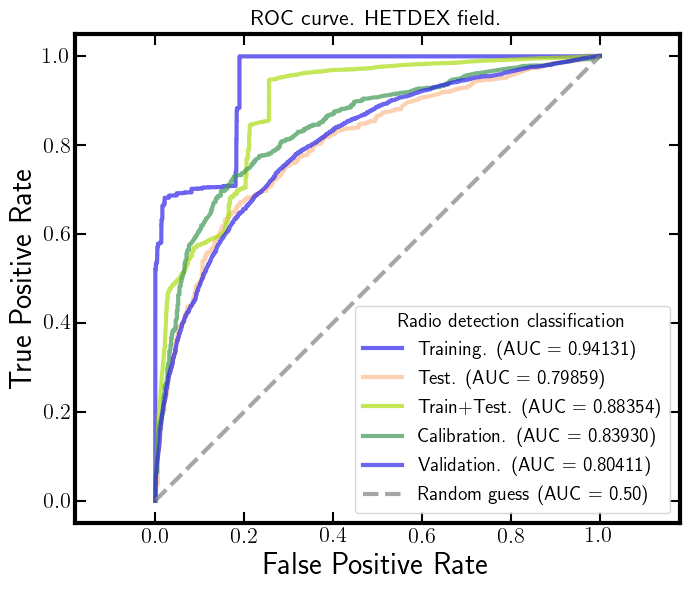

In [95]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = RocCurveDisplay(fpr=fpr_train,      tpr=tpr_train,      roc_auc=roc_auc_train)
viz_test        = RocCurveDisplay(fpr=fpr_test,       tpr=tpr_test,       roc_auc=roc_auc_test)
viz_train_test  = RocCurveDisplay(fpr=fpr_train_test, tpr=tpr_train_test, roc_auc=roc_auc_train_test)
viz_calib       = RocCurveDisplay(fpr=fpr_calib,      tpr=tpr_calib,      roc_auc=roc_auc_calib)
viz_val         = RocCurveDisplay(fpr=fpr_val,        tpr=tpr_val,        roc_auc=roc_auc_validation)
viz_train.plot(ax=ax1,       lw=3, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.7, label=f"Training.    (AUC = {roc_auc_train:0.5f})")
viz_test.plot(ax=ax1,        lw=3, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.7, label=f"Test.        (AUC = {roc_auc_test:0.5f})")
viz_train_test.plot(ax=ax1,  lw=3, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.7, label=f"Train+Test.  (AUC = {roc_auc_train_test:0.5f})")
viz_calib.plot(ax=ax1,       lw=3, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.7, label=f"Calibration. (AUC = {roc_auc_calib:0.5f})")
viz_val.plot(ax=ax1,         lw=3, c=cm.get_cmap('cet_CET_C2s')(1.0), alpha=0.7, label=f"Validation.  (AUC = {roc_auc_validation:0.5f})")

ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('False Positive Rate', fontsize=22)
ax1.set_ylabel('True Positive Rate', fontsize=22)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=3.0)
plt.setp(ax1.spines.values(), linewidth=3.0)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=4, fontsize=14, title='Radio detection classification', title_fontsize=14)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('ROC curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'AUC_ROC_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

##### Obtain optimal thresholds from each sub-set

In [96]:
opt_thres_train      = thresh_train[np.argmax(tpr_train - fpr_train)]
opt_thres_test       = thresh_test[np.argmax(tpr_test - fpr_test)]
opt_thres_train_test = thresh_train_test[np.argmax(tpr_train_test - fpr_train_test)]
opt_thres_calib      = thresh_calib[np.argmax(tpr_calib - fpr_calib)]
opt_thres_validation = thresh_val[np.argmax(tpr_val - fpr_val)]

In [97]:
print(f'Optimal threshold from area under the curve (ROC) for training    = {opt_thres_train:.8e}')
print(f'Optimal threshold from area under the curve (ROC) for test        = {opt_thres_test:.8e}')
print(f'Optimal threshold from area under the curve (ROC) for train+test  = {opt_thres_train_test:.8e}')
print(f'Optimal threshold from area under the curve (ROC) for calibration = {opt_thres_calib:.8e}')
print(f'Optimal threshold from area under the curve (ROC) for validation  = {opt_thres_validation:.8e}')

Optimal threshold from area under the curve (ROC) for training    = 4.98223560e-01
Optimal threshold from area under the curve (ROC) for test        = 5.00909376e-01
Optimal threshold from area under the curve (ROC) for train+test  = 4.98463461e-01
Optimal threshold from area under the curve (ROC) for calibration = 5.00092803e-01
Optimal threshold from area under the curve (ROC) for validation  = 4.98470689e-01


##### Precision-Recall curve

In [98]:
prec_train,      recall_train,      thresh_train      = precision_recall_curve(train_prediction_clf.loc[:, target_feat],\
                                                                               train_prediction_clf.loc[:, 'Score_1'],      pos_label=1)
prec_test,       recall_test,       thresh_test       = precision_recall_curve(test_prediction_clf.loc[:, target_feat],\
                                                                               test_prediction_clf.loc[:, 'Score_1'],       pos_label=1)
prec_train_test, recall_train_test, thresh_train_test = precision_recall_curve(train_test_prediction_clf.loc[:, target_feat],\
                                                                               train_test_prediction_clf.loc[:, 'Score_1'], pos_label=1)
prec_calib,      recall_calib,      thresh_calib      = precision_recall_curve(calib_prediction_clf.loc[:, target_feat],\
                                                                               calib_prediction_clf.loc[:, 'Score_1'],      pos_label=1)
prec_validation, recall_validation, thresh_validation = precision_recall_curve(validation_prediction_clf.loc[:, target_feat],\
                                                                               validation_prediction_clf.loc[:, 'Score_1'], pos_label=1)

AUC for PR curve

In [99]:
auc_pr_train      = auc(recall_train,      prec_train)
auc_pr_test       = auc(recall_test,       prec_test)
auc_pr_train_test = auc(recall_train_test, prec_train_test)
auc_pr_calib      = auc(recall_calib,      prec_calib)
auc_pr_validation = auc(recall_validation, prec_validation)

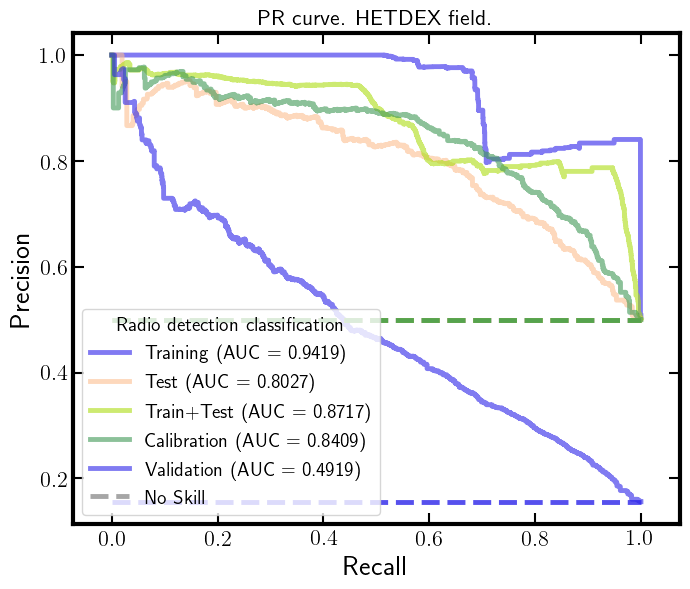

In [100]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = PrecisionRecallDisplay(precision=prec_train,      recall=recall_train)
viz_test        = PrecisionRecallDisplay(precision=prec_test,       recall=recall_test)
viz_train_test  = PrecisionRecallDisplay(precision=prec_train_test, recall=recall_train_test)
viz_calib       = PrecisionRecallDisplay(precision=prec_calib,      recall=recall_calib)
viz_val         = PrecisionRecallDisplay(precision=prec_validation, recall=recall_validation)
viz_train.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.6, label=f"Training    (AUC = {auc_pr_train:.4f})")
viz_test.plot(ax=ax1,        lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.6, label=f"Test        (AUC = {auc_pr_test:.4f})")
viz_train_test.plot(ax=ax1,  lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.6, label=f"Train+Test  (AUC = {auc_pr_train_test:.4f})")
viz_calib.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.6, label=f"Calibration (AUC = {auc_pr_calib:.4f})")
viz_val.plot(ax=ax1,         lw=3.5, c=cm.get_cmap('cet_CET_C2s')(1.0), alpha=0.6, label=f"Validation  (AUC = {auc_pr_validation:.4f})")

no_skill_train      = np.sum(train_prediction_clf.loc[:, target_feat] == 1)      / len(train_prediction_clf.loc[:, target_feat])
no_skill_test       = np.sum(test_prediction_clf.loc[:, target_feat] == 1)       / len(test_prediction_clf.loc[:, target_feat])
no_skill_train_test = np.sum(train_test_prediction_clf.loc[:, target_feat] == 1) / len(train_test_prediction_clf.loc[:, target_feat])
no_skill_calib      = np.sum(calib_prediction_clf.loc[:, target_feat] == 1)      / len(calib_prediction_clf.loc[:, target_feat])
no_skill_val        = np.sum(validation_prediction_clf.loc[:, target_feat] == 1) / len(validation_prediction_clf.loc[:, target_feat])
ax1.plot([0, 1], [no_skill_train,      no_skill_train],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_test,       no_skill_test],       ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_train_test, no_skill_train_test], ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_calib,      no_skill_calib],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_val,        no_skill_val],        ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(1.0), alpha=0.8, lw=3.5)
ax1.plot([1, 1], [1, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.5, label='No Skill', zorder=0)

ax1.set_xlabel('Recall', fontsize=20)
ax1.set_ylabel('Precision', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=3.0)
plt.setp(ax1.spines.values(), linewidth=3.0)
# ax1.set_aspect('equal', 'box')
plt.legend(loc='best', fontsize=14, title='Radio detection classification', title_fontsize=14)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('PR curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'PR_curve_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

Find optimal threshold from PR curve

In [101]:
fscore_train      = (1 + gv.beta_F**2) * (prec_train      * recall_train)      / (prec_train * gv.beta_F**2      + recall_train)
fscore_test       = (1 + gv.beta_F**2) * (prec_test       * recall_test)       / (prec_test * gv.beta_F**2       + recall_test)
fscore_train_test = (1 + gv.beta_F**2) * (prec_train_test * recall_train_test) / (prec_train_test * gv.beta_F**2 + recall_train_test)
fscore_calib      = (1 + gv.beta_F**2) * (prec_calib      * recall_calib)      / (prec_calib * gv.beta_F**2      + recall_calib)
fscore_validation = (1 + gv.beta_F**2) * (prec_validation * recall_validation) / (prec_validation * gv.beta_F**2 + recall_validation)

In [102]:
opt_t_PR_train      = thresh_train[np.argmax(fscore_train)]
opt_t_PR_test       = thresh_test[np.argmax(fscore_test)]
opt_t_PR_train_test = thresh_train_test[np.argmax(fscore_train_test)]
opt_t_PR_calib      = thresh_calib[np.argmax(fscore_calib)]
opt_t_PR_validation = thresh_validation[np.argmax(fscore_validation)]

In [103]:
print(f'Optimal threshold from Precision-Recall curve for training    = {opt_t_PR_train:.8e}')
print(f'Optimal threshold from Precision-Recall curve for test        = {opt_t_PR_test:.8e}')
print(f'Optimal threshold from Precision-Recall curve for train+test  = {opt_t_PR_train_test:.8e}')
print(f'Optimal threshold from Precision-Recall curve for calibration = {opt_t_PR_calib:.8e}')
print(f'Optimal threshold from Precision-Recall curve for validation  = {opt_t_PR_validation:.8e}')

Optimal threshold from Precision-Recall curve for training    = 4.98223560e-01
Optimal threshold from Precision-Recall curve for test        = 4.94479916e-01
Optimal threshold from Precision-Recall curve for train+test  = 4.98463461e-01
Optimal threshold from Precision-Recall curve for calibration = 4.93069459e-01
Optimal threshold from Precision-Recall curve for validation  = 5.05052878e-01


In [104]:
print(f'The selected threshold, from train+test sub-set is {opt_t_PR_train_test:.5f}')
print(f'And, in its complete extension, is {opt_t_PR_train_test}')

The selected threshold, from train+test sub-set is 0.49846
And, in its complete extension, is 0.4984634611


---

In [105]:
radio_pred_threshold = float(opt_t_PR_train_test) # 4.97101925e-01

In [106]:
train_prediction_clf      = pyc.predict_model(final_radio_clf, data=train_df,       probability_threshold=radio_pred_threshold, raw_score=True, round=10)
test_prediction_clf       = pyc.predict_model(final_radio_clf, data=test_df,        probability_threshold=radio_pred_threshold, raw_score=True, round=10)
train_test_prediction_clf = pyc.predict_model(final_radio_clf, data=train_test_df,  probability_threshold=radio_pred_threshold, raw_score=True, round=10)
calib_prediction_clf      = pyc.predict_model(final_radio_clf, data=calibration_df, probability_threshold=radio_pred_threshold, raw_score=True, round=10)
validation_prediction_clf = pyc.predict_model(final_radio_clf, data=validation_df,  probability_threshold=radio_pred_threshold, raw_score=True, round=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.8799887048,0.9413118400,0.9493599398,0.8336915193,0.8877739636,0.7599774096,0.7673993163,0.8932803869


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.7272047833,0.7985917003,0.7189835575,0.7310030395,0.7249434815,0.4544095665,0.4544710047,0.7243729234


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.8258721365,0.8835412647,0.9076209013,0.7800797838,0.8390311419,0.6517442731,0.6606339328,0.8450997472


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.7686246418,0.8392993489,0.7707736390,0.7674750357,0.7691208006,0.5372492837,0.5372542460,0.7692775726


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.7295487894,0.8041100937,0.7368731563,0.3328891258,0.4586010648,0.3110652753,0.3547054177,0.4756701291


Create confusion matrices.

In [107]:
cm_mat_train      = gf.conf_mat_func(train_prediction_clf[target_feat],      train_prediction_clf['Label'])
cm_mat_test       = gf.conf_mat_func(test_prediction_clf[target_feat],       test_prediction_clf['Label'])
cm_mat_train_test = gf.conf_mat_func(train_test_prediction_clf[target_feat], train_test_prediction_clf['Label'])
cm_mat_calib      = gf.conf_mat_func(calib_prediction_clf[target_feat],      calib_prediction_clf['Label'])
cm_mat_val        = gf.conf_mat_func(validation_prediction_clf[target_feat], validation_prediction_clf['Label'])

In [108]:
radio_scores_array_df = gf.create_scores_df([cm_mat_train, cm_mat_test, cm_mat_train_test, cm_mat_calib, cm_mat_val],\
                       ['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                       ['F-\u03B2', 'MCC', 'Precision', 'Recall', 'ACC'])

In [109]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(radio_scores_array_df.drop(columns=['ACC']))

,F-β,MCC,Precision,Recall
Train,0.8933,0.7674,0.8337,0.9494
Test,0.7244,0.4545,0.7310,0.7190
Train+Test,0.8451,0.6606,0.7801,0.9076
Calibration,0.7693,0.5373,0.7675,0.7708
Validation,0.4757,0.3547,0.3329,0.7369


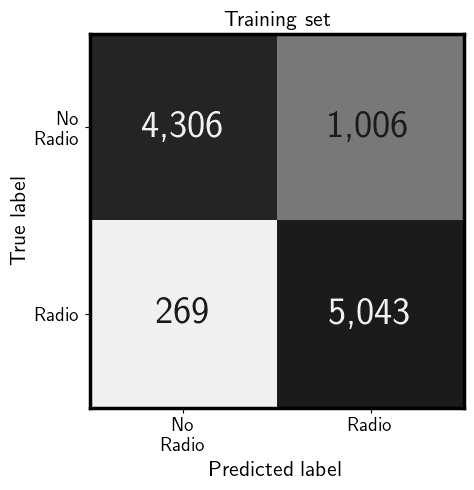

In [110]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_mat_train, title='Training set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
plt.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

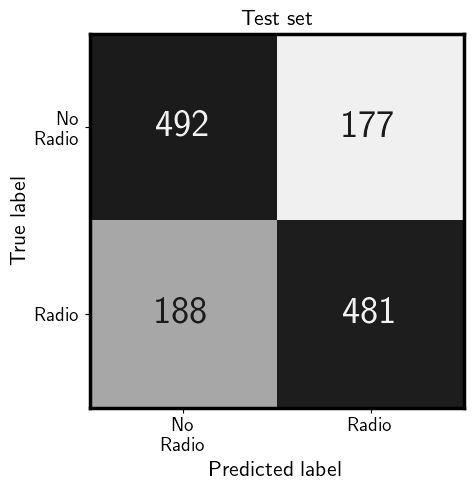

In [111]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_mat_test, title='Test set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
plt.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_test_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

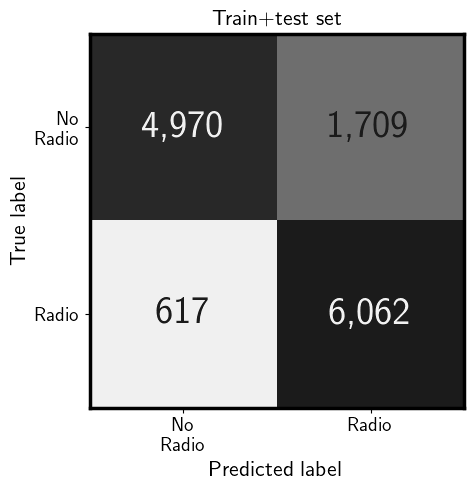

In [112]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_mat_train_test, title='Train+test set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
plt.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_test_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

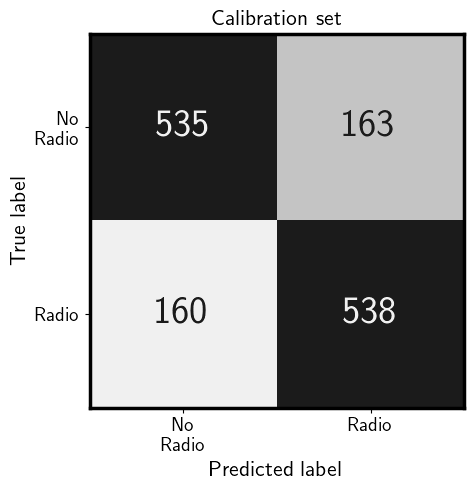

In [113]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

_ = gf.plot_conf_mat(cm_mat_calib, title='Calibration set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
plt.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_calibration_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

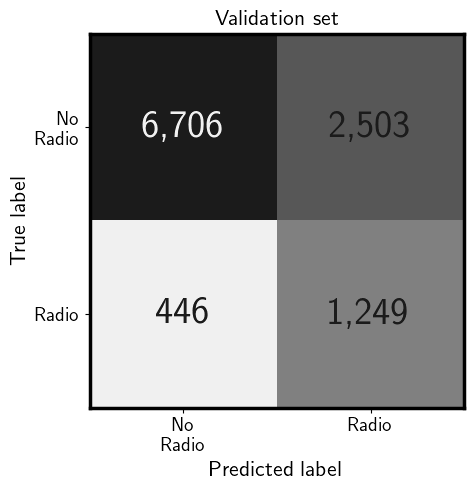

In [114]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

_ = gf.plot_conf_mat(cm_mat_val, title='Validation set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
plt.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_validation_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

### Calibrate model and save it separately

In [115]:
print('Running data pre-processing for calibration (train+test):\n')
extended_calibration_df = gf.preprocess_data(final_radio_clf, calibration_df, base_models_names)
initial_cols            = extended_calibration_df.columns.drop(base_models_names)

Running data pre-processing for calibration (train+test):



In [116]:
if not save_model_flag:
    calibrated_final_radio_clf = BetaCalibration(parameters='abm')
    calibrated_final_radio_clf.fit(calib_prediction_clf.loc[:, 'Score_1'], calib_prediction_clf.loc[:, target_feat])

In [117]:
calibrated_final_radio_clf = BetaCalibration(parameters='abm')
calibrated_final_radio_clf.fit(calib_prediction_clf.loc[:, 'Score_1'], calib_prediction_clf.loc[:, target_feat])
# if save_model_flag:
#     calibrated_final_radio_clf = BetaCalibration(parameters='abm')
#     calibrated_final_radio_clf.fit(calib_prediction_clf.loc[:, 'Score_1'], calib_prediction_clf.loc[:, target_feat])
#     dump(calibrated_final_radio_clf, gv.models_path + gv.cal_radio_model)

BetaCalibration(parameters='abm')

In [118]:
# if load_model_flag:
#     calibrated_final_radio_clf = load(gv.models_path + gv.cal_radio_model)

In [119]:
train_prediction_clf['Prob_radio']      = calibrated_final_radio_clf.predict(train_prediction_clf.loc[:, 'Score_1'])
test_prediction_clf['Prob_radio']       = calibrated_final_radio_clf.predict(test_prediction_clf.loc[:, 'Score_1'])
train_test_prediction_clf['Prob_radio'] = calibrated_final_radio_clf.predict(train_test_prediction_clf.loc[:, 'Score_1'])
calib_prediction_clf['Prob_radio']      = calibrated_final_radio_clf.predict(calib_prediction_clf.loc[:, 'Score_1'])
validation_prediction_clf['Prob_radio'] = calibrated_final_radio_clf.predict(validation_prediction_clf.loc[:, 'Score_1'])

In [120]:
train_prediction_clf['Label_cal_naive']      = np.array(train_prediction_clf.loc[:, 'Prob_radio']      >= gv.naive_radio_thresh).astype(int)
test_prediction_clf['Label_cal_naive']       = np.array(test_prediction_clf.loc[:, 'Prob_radio']       >= gv.naive_radio_thresh).astype(int)
train_test_prediction_clf['Label_cal_naive'] = np.array(train_test_prediction_clf.loc[:, 'Prob_radio'] >= gv.naive_radio_thresh).astype(int)
calib_prediction_clf['Label_cal_naive']      = np.array(calib_prediction_clf.loc[:, 'Prob_radio']      >= gv.naive_radio_thresh).astype(int)
validation_prediction_clf['Label_cal_naive'] = np.array(validation_prediction_clf.loc[:, 'Prob_radio'] >= gv.naive_radio_thresh).astype(int)

In [121]:
cm_mat_val_cal_naive        = gf.conf_mat_func(validation_prediction_clf[target_feat], validation_prediction_clf['Label_cal_naive'])
cm_mat_train_cal_naive      = gf.conf_mat_func(train_prediction_clf[target_feat],      train_prediction_clf['Label_cal_naive'])
cm_mat_test_cal_naive       = gf.conf_mat_func(test_prediction_clf[target_feat],       test_prediction_clf['Label_cal_naive'])
cm_mat_calib_cal_naive      = gf.conf_mat_func(calib_prediction_clf[target_feat],      calib_prediction_clf['Label_cal_naive'])
cm_mat_train_test_cal_naive = gf.conf_mat_func(train_test_prediction_clf[target_feat], train_test_prediction_clf['Label_cal_naive'])

In [122]:
radio_scores_cal_naive_df = gf.create_scores_df([cm_mat_train_cal_naive, cm_mat_test_cal_naive,\
                                              cm_mat_train_test_cal_naive, cm_mat_calib_cal_naive, cm_mat_val_cal_naive],\
                       ['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                       ['F-\u03B2', 'MCC', 'Precision', 'Recall', 'ACC'])

In [123]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(radio_scores_cal_naive_df.drop(columns=['ACC']))

,F-β,MCC,Precision,Recall
Train,0.8539,0.6954,0.8273,0.8773
Test,0.7158,0.4790,0.7713,0.6756
Train+Test,0.8214,0.6298,0.7983,0.8414
Calibration,0.7608,0.5541,0.8051,0.7278
Validation,0.4856,0.3648,0.3613,0.6785


##### Obtain optimal thresholds from train+test in calibrated model

##### Precision-Recall curve

In [124]:
prec_train_cal,      recall_train_cal,      thresh_train_cal      = precision_recall_curve(train_prediction_clf.loc[:, target_feat],\
                                                                               train_prediction_clf.loc[:, 'Prob_radio'],      pos_label=1)
prec_test_cal,       recall_test_cal,       thresh_test_cal       = precision_recall_curve(test_prediction_clf.loc[:, target_feat],\
                                                                               test_prediction_clf.loc[:, 'Prob_radio'],       pos_label=1)
prec_train_test_cal, recall_train_test_cal, thresh_train_test_cal = precision_recall_curve(train_test_prediction_clf.loc[:, target_feat],\
                                                                               train_test_prediction_clf.loc[:, 'Prob_radio'], pos_label=1)
prec_calib_cal,      recall_calib_cal,      thresh_calib_cal      = precision_recall_curve(calib_prediction_clf.loc[:, target_feat],\
                                                                               calib_prediction_clf.loc[:, 'Prob_radio'],      pos_label=1)
prec_validation_cal, recall_validation_cal, thresh_validation_cal = precision_recall_curve(validation_prediction_clf.loc[:, target_feat],\
                                                                               validation_prediction_clf.loc[:, 'Prob_radio'], pos_label=1)

AUC for PR curve

In [125]:
auc_pr_train_cal      = auc(recall_train_cal,      prec_train_cal)
auc_pr_test_cal       = auc(recall_test_cal,       prec_test_cal)
auc_pr_train_test_cal = auc(recall_train_test_cal, prec_train_test_cal)
auc_pr_calib_cal      = auc(recall_calib_cal,      prec_calib_cal)
auc_pr_validation_cal = auc(recall_validation_cal, prec_validation_cal)

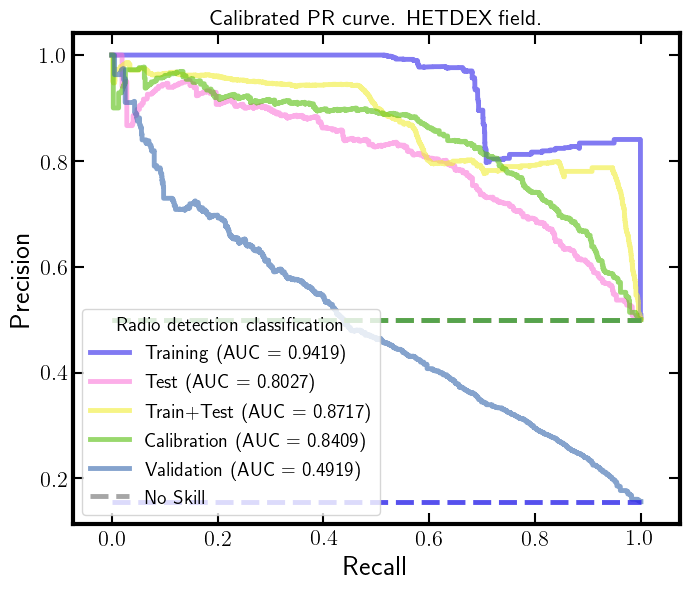

In [126]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = PrecisionRecallDisplay(precision=prec_train_cal,      recall=recall_train_cal)
viz_test        = PrecisionRecallDisplay(precision=prec_test_cal,       recall=recall_test_cal)
viz_train_test  = PrecisionRecallDisplay(precision=prec_train_test_cal, recall=recall_train_test_cal)
viz_calib       = PrecisionRecallDisplay(precision=prec_calib_cal,      recall=recall_calib_cal)
viz_val         = PrecisionRecallDisplay(precision=prec_validation_cal, recall=recall_validation_cal)
viz_train.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.6, label=f"Training    (AUC = {auc_pr_train_cal:.4f})")
viz_test.plot(ax=ax1,        lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.3), alpha=0.6, label=f"Test        (AUC = {auc_pr_test_cal:.4f})")
viz_train_test.plot(ax=ax1,  lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.5), alpha=0.6, label=f"Train+Test  (AUC = {auc_pr_train_test_cal:.4f})")
viz_calib.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.7), alpha=0.6, label=f"Calibration (AUC = {auc_pr_calib_cal:.4f})")
viz_val.plot(ax=ax1,         lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.9), alpha=0.6, label=f"Validation  (AUC = {auc_pr_validation_cal:.4f})")

no_skill_train      = np.sum(train_prediction_clf.loc[:, target_feat] == 1)      / len(train_prediction_clf.loc[:, target_feat])
no_skill_test       = np.sum(test_prediction_clf.loc[:, target_feat] == 1)       / len(test_prediction_clf.loc[:, target_feat])
no_skill_train_test = np.sum(train_test_prediction_clf.loc[:, target_feat] == 1) / len(train_test_prediction_clf.loc[:, target_feat])
no_skill_calib      = np.sum(calib_prediction_clf.loc[:, target_feat] == 1)      / len(calib_prediction_clf.loc[:, target_feat])
no_skill_val        = np.sum(validation_prediction_clf.loc[:, target_feat] == 1) / len(validation_prediction_clf.loc[:, target_feat])
ax1.plot([0, 1], [no_skill_train,      no_skill_train],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_test,       no_skill_test],       ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_train_test, no_skill_train_test], ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_calib,      no_skill_calib],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_val,        no_skill_val],        ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(1.0), alpha=0.8, lw=3.5)
ax1.plot([1, 1], [1, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.5, label='No Skill', zorder=0)

ax1.set_xlabel('Recall', fontsize=20)
ax1.set_ylabel('Precision', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=3.0)
plt.setp(ax1.spines.values(), linewidth=3.0)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=3, fontsize=14, title='Radio detection classification', title_fontsize=14)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('Calibrated PR curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'PR_cal_curve_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

Find optimal threshold from PR curve

In [127]:
fscore_train_cal      = (1 + gv.beta_F**2) * (prec_train_cal      * recall_train_cal)      / (prec_train_cal * gv.beta_F**2      + recall_train_cal)
fscore_test_cal       = (1 + gv.beta_F**2) * (prec_test_cal       * recall_test_cal)       / (prec_test_cal * gv.beta_F**2       + recall_test_cal)
fscore_train_test_cal = (1 + gv.beta_F**2) * (prec_train_test_cal * recall_train_test_cal) / (prec_train_test_cal * gv.beta_F**2 + recall_train_test_cal)
fscore_calib_cal      = (1 + gv.beta_F**2) * (prec_calib_cal      * recall_calib_cal)      / (prec_calib_cal * gv.beta_F**2      + recall_calib_cal)
fscore_validation_cal = (1 + gv.beta_F**2) * (prec_validation_cal * recall_validation_cal) / (prec_validation_cal * gv.beta_F**2 + recall_validation_cal)

In [128]:
opt_t_PR_train_cal      = thresh_train_cal[np.argmax(fscore_train_cal)]
opt_t_PR_test_cal       = thresh_test_cal[np.argmax(fscore_test_cal)]
opt_t_PR_train_test_cal = thresh_train_test_cal[np.argmax(fscore_train_test_cal)]
opt_t_PR_calib_cal      = thresh_calib_cal[np.argmax(fscore_calib_cal)]
opt_t_PR_validation_cal = thresh_validation_cal[np.argmax(fscore_validation_cal)]

In [129]:
print('Otimal thresholds from calibrated Precision-Recal curves:')
print(f'Optimal threshold from Precision-Recall curve for training    = {opt_t_PR_train_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for test        = {opt_t_PR_test_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for train+test  = {opt_t_PR_train_test_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for calibration = {opt_t_PR_calib_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for validation  = {opt_t_PR_validation_cal:.5f}')

Otimal thresholds from calibrated Precision-Recal curves:
Optimal threshold from Precision-Recall curve for training    = 0.45088
Optimal threshold from Precision-Recall curve for test        = 0.34237
Optimal threshold from Precision-Recall curve for train+test  = 0.45812
Optimal threshold from Precision-Recall curve for calibration = 0.30483
Optimal threshold from Precision-Recall curve for validation  = 0.65340


In [130]:
print(f'The selected threshold, from calibration sub-set is {opt_t_PR_calib_cal:.5f}')
print(f'And, in its complete extension, is {opt_t_PR_calib_cal}')

The selected threshold, from calibration sub-set is 0.30483
And, in its complete extension, is 0.304828084390267


In [131]:
train_prediction_clf['Label_cal']      = np.array(train_prediction_clf.loc[:, 'Prob_radio']      >= opt_t_PR_calib_cal).astype(int)
test_prediction_clf['Label_cal']       = np.array(test_prediction_clf.loc[:, 'Prob_radio']       >= opt_t_PR_calib_cal).astype(int)
train_test_prediction_clf['Label_cal'] = np.array(train_test_prediction_clf.loc[:, 'Prob_radio'] >= opt_t_PR_calib_cal).astype(int)
calib_prediction_clf['Label_cal']      = np.array(calib_prediction_clf.loc[:, 'Prob_radio']      >= opt_t_PR_calib_cal).astype(int)
validation_prediction_clf['Label_cal'] = np.array(validation_prediction_clf.loc[:, 'Prob_radio'] >= opt_t_PR_calib_cal).astype(int)

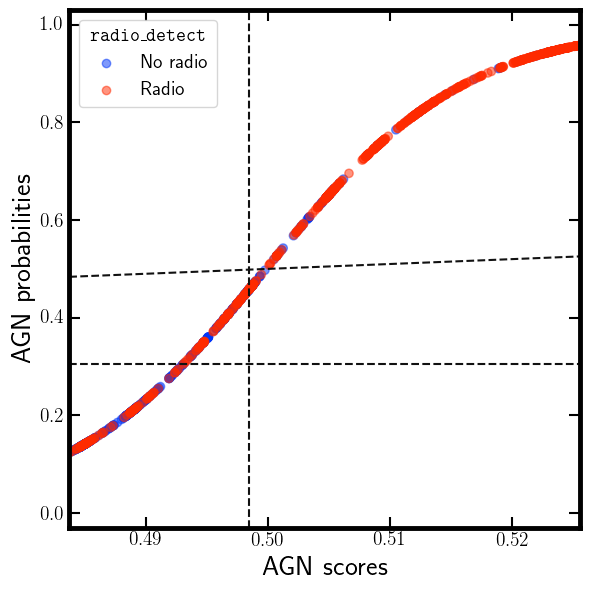

In [132]:
fig             = plt.figure(figsize=(6,6))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')

set_to_plot     = calib_prediction_clf

ax1.scatter(set_to_plot.loc[:, 'Score_1'], set_to_plot.loc[:, 'Prob_radio'], marker='o',\
            alpha=0.5, c=set_to_plot.loc[:, target_feat],\
            cmap=plt.get_cmap('cet_rainbow',len(np.unique(set_to_plot.loc[:, target_feat]))))
ax1.axline([0,0], [1,1], color='k', ls='dashed')
ax1.axhline(y=opt_t_PR_calib_cal, color='k', ls='dashed')
ax1.axvline(x=opt_t_PR_train_test, color='k', ls='dashed')

ax1.scatter([-1.], [-1.], marker='o', alpha=0.5, label='No radio',\
            color=plt.get_cmap('cet_rainbow',len(np.unique(set_to_plot.loc[:, target_feat])))(0.0))
ax1.scatter([-1.], [-1.], marker='o', alpha=0.5, label='Radio',\
            color=plt.get_cmap('cet_rainbow',len(np.unique(set_to_plot.loc[:, target_feat])))(1.0))

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN scores', size=20)
ax1.set_ylabel('AGN probabilities', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.legend(loc='best', fontsize=14, title='$\mathtt{radio\_detect}$', title_fontsize=14)
ax1.set_xlim(left=set_to_plot.loc[:, 'Score_1'].min() * 0.99999, right=set_to_plot.loc[:, 'Score_1'].max() * 1.00001)
ax1.set_ylim(bottom=-0.03, top=1.03)
fig.tight_layout()
plt.show()

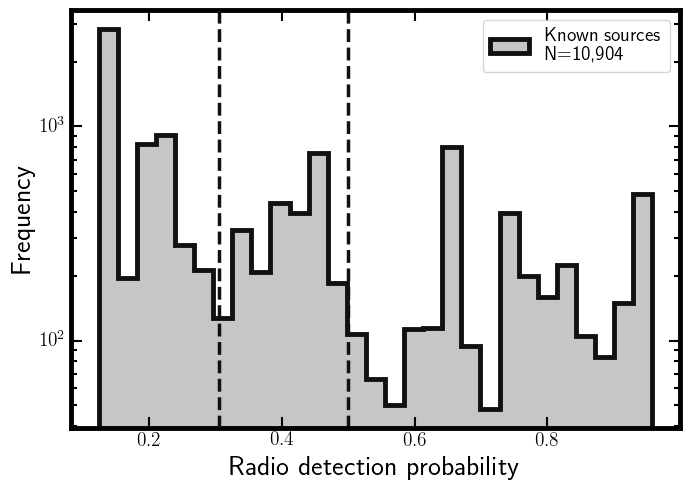

In [133]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

set_to_plot     = validation_prediction_clf

min_score  = np.nanmin(set_to_plot.loc[:, 'Prob_radio'])
max_score  = np.nanmax(set_to_plot.loc[:, 'Prob_radio'])
score_bins = np.linspace(min_score, max_score, 30)

sample_size = len(set_to_plot.loc[:, 'Prob_radio'])

ax1.hist(set_to_plot.loc[:, 'Prob_radio'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label=f'Known sources\nN={sample_size:,}')

ax1.axvline(x=0.5, ls='--', c='k', lw=2.5)
ax1.axvline(x=opt_t_PR_calib_cal, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio detection probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'hist_predicted_radio_cal_scores_pred_AGN_known.pdf', bbox_inches='tight')
plt.show()

#### Calibration curve

In [134]:
fract_positiv_train_test_cal, mean_pred_val_train_test_cal =\
                        calibration_curve(train_test_prediction_clf.loc[:, target_feat],\
                                          train_test_prediction_clf.loc[:, 'Prob_radio'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_calib_cal, mean_pred_val_calib_cal =\
                        calibration_curve(calib_prediction_clf.loc[:, target_feat],\
                                          calib_prediction_clf.loc[:, 'Prob_radio'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_val_cal, mean_pred_val_val_cal =\
                        calibration_curve(validation_prediction_clf.loc[:, target_feat],\
                                          validation_prediction_clf.loc[:, 'Prob_radio'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

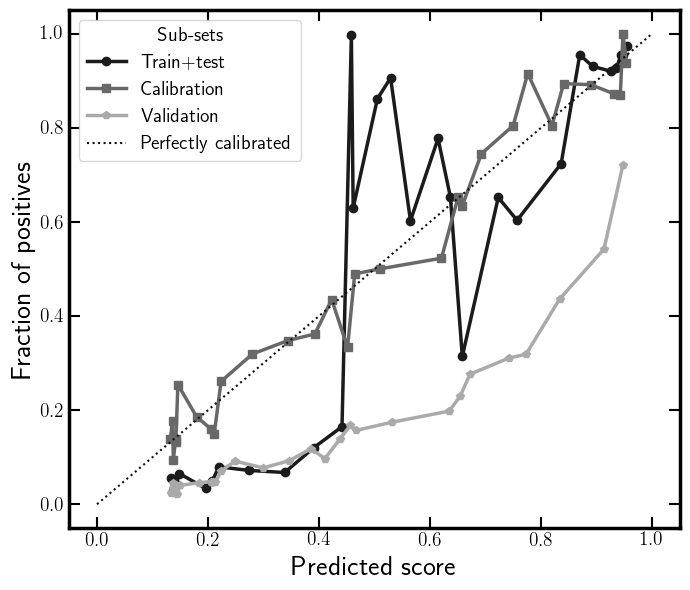

In [135]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

ax1.plot(mean_pred_val_train_test_cal, fract_positiv_train_test_cal, ls='-',\
         marker='o', c=plt.get_cmap(gv.cmap_conf_matr)(1.0), lw=2.5, label='Train+test')
ax1.plot(mean_pred_val_calib_cal, fract_positiv_calib_cal, ls='-', marker='s',\
         c=plt.get_cmap(gv.cmap_conf_matr)(0.6), lw=2.5, label='Calibration')
ax1.plot(mean_pred_val_val_cal, fract_positiv_val_cal, ls='-', marker='p',\
         c=plt.get_cmap(gv.cmap_conf_matr)(0.3), lw=2.5, label='Validation')
ax1.plot([0, 1], [0, 1], ls=':', c='k', label='Perfectly calibrated')
ax1.set_xlabel('Predicted score', fontsize=20)
ax1.set_ylabel('Fraction of positives', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.legend(loc='best', fontsize=14, title='Sub-sets', title_fontsize=14)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'calib_curves_post_calib_radio.pdf', bbox_inches='tight')
plt.show()

### Check if calibration was useful

Brier score is used for this. And, in particular, Brier Skill Score (BSS).  
Its values can be in the range $[0, 1]$

If BSS $\ll 0$, calibration was not succesful. If BSS $\approx 0$, it performs as the previous model.  
If BSS $\gg 0$, calibration is useful and performs better than original model.

In [136]:
BS_ref = brier_score_loss(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Label'],     pos_label=1)
BS     = brier_score_loss(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Label_cal'], pos_label=1)
BSS    = 1 - (BS/BS_ref)

In [137]:
print(f'Brier Skill Score is {BSS:.3f} using the validation set.')

Brier Skill Score is -0.481 using the validation set.


Create confusion matrices.

In [138]:
cm_mat_val_cal        = gf.conf_mat_func(validation_prediction_clf[target_feat], validation_prediction_clf['Label_cal'])
cm_mat_train_cal      = gf.conf_mat_func(train_prediction_clf[target_feat],      train_prediction_clf['Label_cal'])
cm_mat_test_cal       = gf.conf_mat_func(test_prediction_clf[target_feat],       test_prediction_clf['Label_cal'])
cm_mat_calib_cal      = gf.conf_mat_func(calib_prediction_clf[target_feat],      calib_prediction_clf['Label_cal'])
cm_mat_train_test_cal = gf.conf_mat_func(train_test_prediction_clf[target_feat], train_test_prediction_clf['Label_cal'])

In [139]:
radio_scores_cal_df = gf.create_scores_df([cm_mat_train_cal, cm_mat_test_cal,\
                                              cm_mat_train_test_cal, cm_mat_calib_cal, cm_mat_val_cal],\
                       ['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                       ['F-\u03B2', 'MCC', 'Precision', 'Recall', 'ACC'])

In [140]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(radio_scores_cal_df.drop(columns=['ACC']))

,F-β,MCC,Precision,Recall
Train,0.8463,0.6535,0.7142,0.9991
Test,0.7435,0.4124,0.6550,0.8371
Train+Test,0.8188,0.5827,0.6890,0.9699
Calibration,0.7776,0.4922,0.6850,0.8754
Validation,0.4214,0.2977,0.2607,0.8590


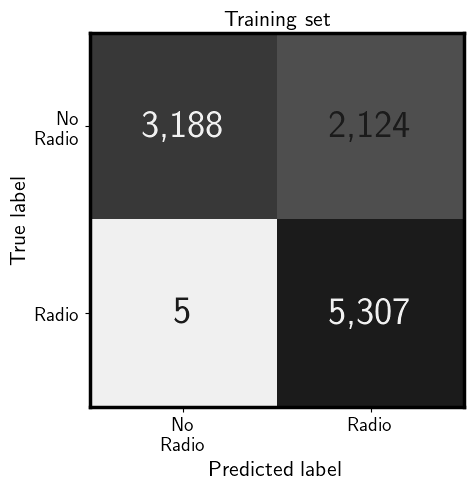

In [141]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_mat_train_cal, title='Training set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_classification_radio_detect_cal.pdf', bbox_inches='tight')
plt.show()

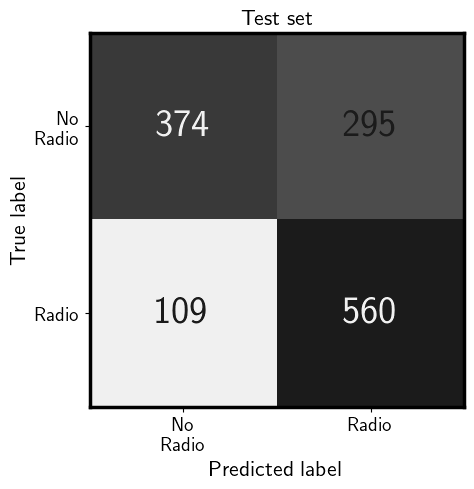

In [142]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_mat_test_cal, title='Test set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_test_classification_radio_detect_cal.pdf', bbox_inches='tight')
plt.show()

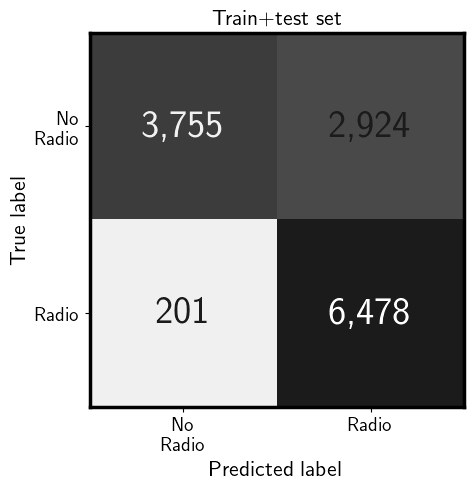

In [143]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
ax1 = gf.plot_conf_mat(cm_mat_train_test_cal, title='Train+test set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
ax1.texts[3].set_color('white')
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_test_classification_radio_detect_cal.pdf', bbox_inches='tight')
plt.show()

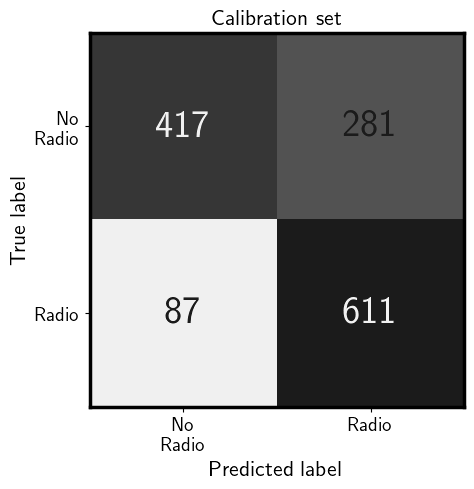

In [144]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

_ = gf.plot_conf_mat(cm_mat_calib_cal, title='Calibration set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_calibration_classification_radio_detect_cal.pdf', bbox_inches='tight')
plt.show()

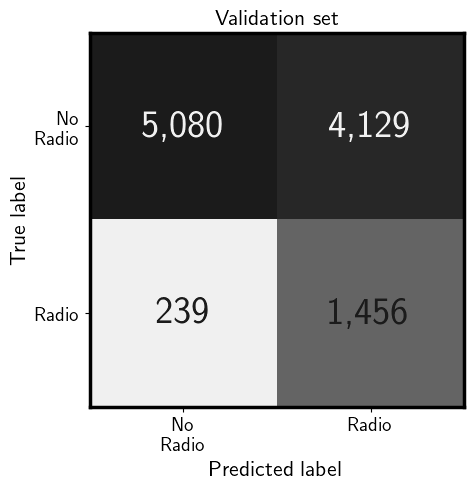

In [145]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

_ = gf.plot_conf_mat(cm_mat_val_cal, title='Validation set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_validation_classification_radio_detect_cal.pdf', bbox_inches='tight')
plt.show()